
# **Use Case: Economic Resilience of Small Businesses Post-COVID in Melbourne**
# **Owner:** Diyona Robert  
# **Branch:** `Diyona_Robert`  
# **Last updated:** 21-08-2025

#  **1. Problem Statement** (Business Context)
# Melbourne experienced prolonged COVID impacts. We want to assess whether **small businesses (1–19 jobs)** showed signs of resilience in the post-COVID period, and whether their recovery aligns with **pedestrian activity** as a proxy for economic activity.

# **Business questions:**
# - Q1: Did small-business **establishments** and **jobs** recover post-COVID?
# - Q2: Does the **foot-traffic recovery** track with small-business recovery over time?

# **Success/Completion criteria (mid-trimester):**
# - Load and validate both datasets
# - Aggregate to comparable time units (annual)
# - Produce clear visuals and a 2019→2023 %-change summary
# - Provide a short interpretation + next steps



#  2. Data Sources
# - **Business Establishments & Jobs by Business Size and Industry (City of Melbourne)**
#   - Portal: https://data.melbourne.vic.gov.au/explore/dataset/business-establishments-and-jobs-data-by-business-size-and-industry/information/
#   - Direct CSV (used here): https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/business-establishments-and-jobs-data-by-business-size-and-industry/exports/csv?delimiter=%2C
# - **Pedestrian Counting System – Monthly Counts per Hour (City of Melbourne)**
#   - Portal: https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/
#   - Direct CSV (used here): https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/pedestrian-counting-system-monthly-counts-per-hour/exports/csv?delimiter=%2C

# **Notes on comparability:**
# - Business dataset uses **census_year** and groups by **business_size**.
# - Pedestrian dataset is hourly across sensors; we aggregate **annually** city-wide to compare trends.



#  3. Assumptions & Constraints
# - We treat **2019** as pre-COVID and **2023** as post-COVID reference years.
# - "Small business" ≈ **1–19 jobs**, matched via `business_size` text.
# - We aggregate pedestrians city-wide (sum of all sensors) to align with business totals.
# - This is a mid-trimester checkpoint: no modeling, only trend comparison & basic interpretation.



# 4. Setup
# Imports, display options, and utility helpers. All functions include docstrings for clarity.


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

def pct_change_between_years(df, value_col, year_col, y0, y1):
    """Percent change of `value_col` between years y0 -> y1."""
    a = df.loc[df[year_col] == y0, value_col]
    b = df.loc[df[year_col] == y1, value_col]
    if a.empty or b.empty or a.iloc[0] == 0:
        return np.nan
    return (b.iloc[0] - a.iloc[0]) / abs(a.iloc[0]) * 100

# 5. Load Data
# Loads both datasets directly from the City of Melbourne portal.


In [5]:
# Local paths
PED_PATH = "pedestrian-counting-system-monthly-counts-per-hour.csv"
BIZ_PATH = "business-establishments-and-jobs-data-by-business-size-and-industry.csv"

# Read CSVs
ped = pd.read_csv(PED_PATH)
biz = pd.read_csv(BIZ_PATH)

# Fix known typo if present
biz.columns = [c.replace("ANZSIC indusrty", "ANZSIC industry") for c in biz.columns]

# Coerce dtypes NOW to avoid weird plots later
biz["Census year"] = pd.to_numeric(biz["Census year"], errors="coerce")
biz["Total establishments"] = pd.to_numeric(biz["Total establishments"], errors="coerce")
biz["Total jobs"] = pd.to_numeric(biz["Total jobs"], errors="coerce")
biz = biz.dropna(subset=["Census year"])

ped["sensing_date"] = pd.to_datetime(ped["sensing_date"], errors="coerce")
ped["pedestriancount"] = pd.to_numeric(ped["pedestriancount"], errors="coerce").fillna(0)

print("ped shape:", ped.shape, " | biz shape:", biz.shape)
display(ped.head(2)); display(biz.head(2))


ped shape: (1387730, 9)  | biz shape: (15414, 7)


,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location
0,72420250407,72,2025-04-07,4,1,3,4,ACMI_T,"-37.81726338, 144.96872809"
1,1420240312,1,2024-03-12,4,8,2,10,Bou292_T,"-37.81349441, 144.96515323"


,Census year,CLUE small area,ANZSIC industry,CLUE industry,Business size,Total establishments,Total jobs
0,2004,Kensington,Wholesale Trade,Wholesale Trade,Small business,16,125.0
1,2004,Melbourne (CBD),Accommodation and Food Services,Accommodation,Large business,3,1245.0


# 6. Data Cleaning & Standardisation
# - Parse pedestrian datetime and derive **year**.
# - Consolidate business columns to lower_snake_case.
# - Filter to **small businesses (1–19 jobs)**.


In [6]:
#  Pedestrian cleaning
# Month & Year for time series
ped["month"] = ped["sensing_date"].dt.to_period("M").dt.to_timestamp()
ped["year"]  = ped["sensing_date"].dt.year

# drop clearly invalid dates if any
ped = ped.dropna(subset=["sensing_date"])

# ---- Business cleaning ----
# Keep only the needed columns and tidy labels
biz = biz.rename(columns={
    "Census year": "year",
    "Business size": "business_size",
    "Total establishments": "total_establishments",
    "Total jobs": "total_jobs"
})

# for the non employing table sizes later:
size_year_tbl = (biz.groupby(["year","business_size"])["total_establishments"]
                   .sum()
                   .unstack(fill_value=0)
                   .sort_index())

# Shares by year (each year sums to 1.0)
size_share_tbl = size_year_tbl.div(size_year_tbl.sum(axis=1), axis=0)


# 7. Aggregation & Integration
# - Pedestrians: sum **annual** counts across all sensors.
# - Business (small only): sum **annual** establishments and jobs.
# - Merge on **year**.


In [7]:
# Annual pedestrians (sum across all sensors)
ped_annual = (ped.groupby("year")["pedestriancount"]
                .sum()
                .sort_index()
                .reset_index())

# Monthly pedestrians (city-wide)
ped_monthly = (ped.groupby("month")["pedestriancount"]
                 .sum()
                 .sort_index()
                 .reset_index())

if len(ped_monthly) >= 2:
    last_month_val = ped_monthly.iloc[-1, 1]
    prev_month_val = ped_monthly.iloc[-2, 1]
    # Heuristic: if last month < 60% of previous month, treat as partial and drop
    if prev_month_val > 0 and last_month_val < 0.6 * prev_month_val:
        ped_monthly = ped_monthly.iloc[:-1, :]

# Business totals by year (sum across all CLUE areas)
biz_annual = (biz.groupby("year")[["total_establishments","total_jobs"]]
                .sum()
                .sort_index()
                .reset_index())

display(ped_annual.head())
display(biz_annual.head())
display(size_share_tbl.head())


,year,pedestriancount
0,2023,104281795
1,2024,269247985
2,2025,163333686


,year,total_establishments,total_jobs
0,2002,36417,915027.0
1,2003,36777,921754.0
2,2004,37629,933115.0
3,2005,39975,968008.0
4,2006,41847,1039133.0


business_size,Large business,Medium business,Non employing,Small business
year,,,,
2002,0.022654,0.138809,0.048851,0.789686
2003,0.022922,0.139245,0.048617,0.789216
2004,0.022004,0.138723,0.046958,0.792314
2005,0.020788,0.135084,0.045403,0.798724
2006,0.020360,0.137358,0.047745,0.794537



# 8. Exploratory Analysis (Visuals)
# Two simple visuals are sufficient for mid-trimester:
# 1) Annual trend lines for pedestrians, small establishments, and small jobs
# 2) 2019→2023 percent change comparison


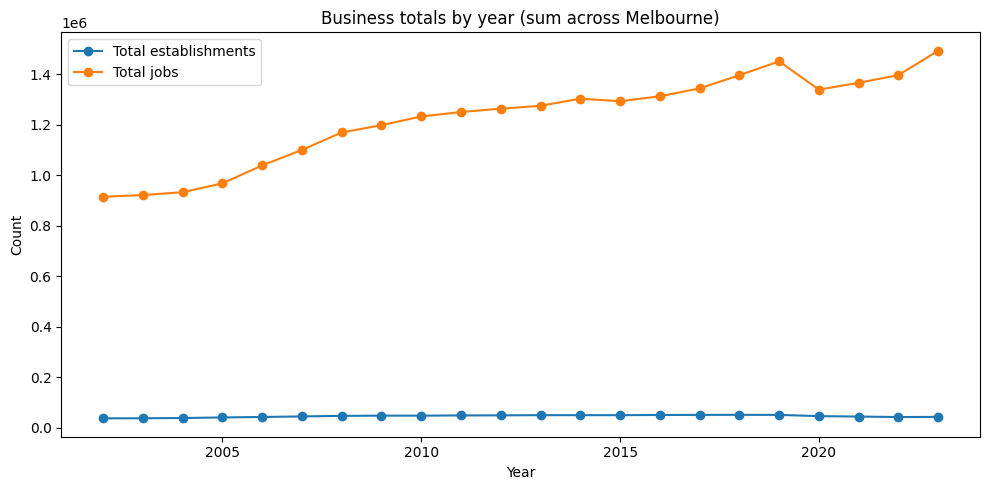

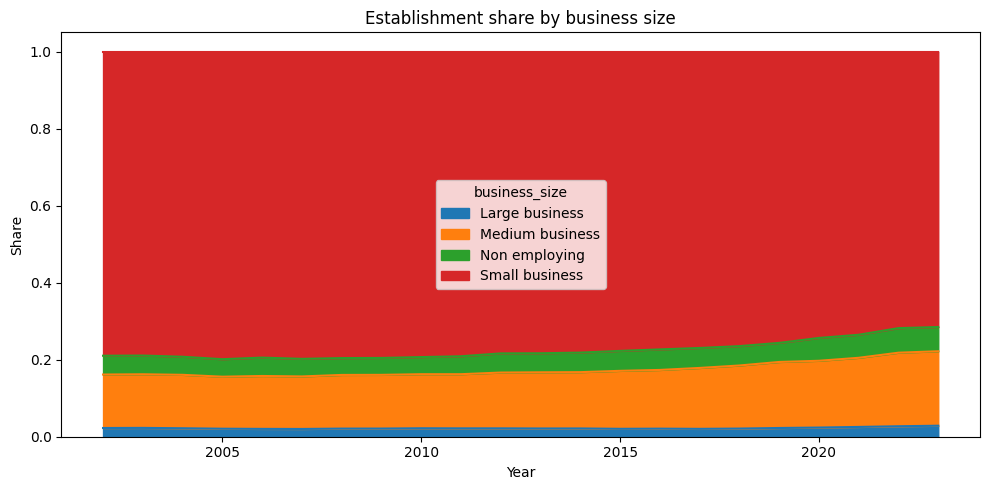

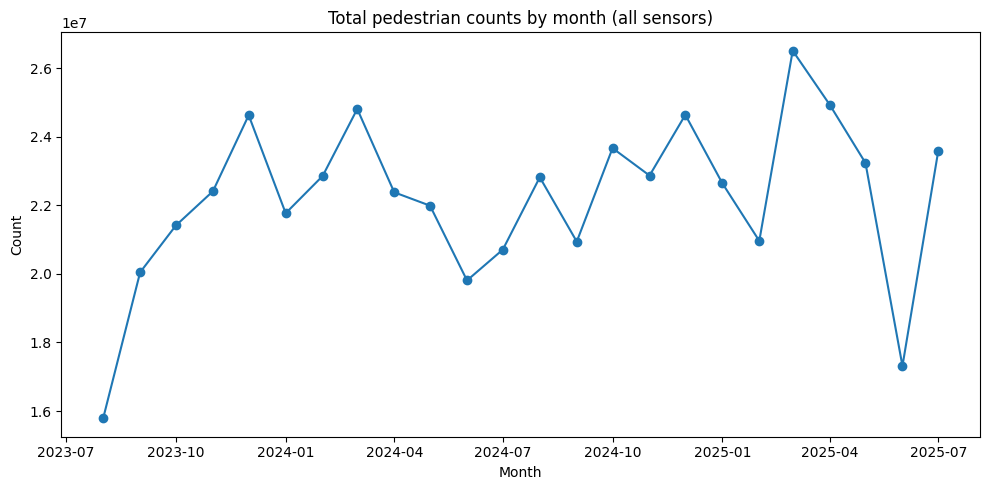

In [8]:
#  Visual 1A: Business totals by year
plt.figure(figsize=(10,5))
plt.plot(biz_annual["year"], biz_annual["total_establishments"], marker="o", label="Total establishments")
plt.plot(biz_annual["year"], biz_annual["total_jobs"], marker="o", label="Total jobs")
plt.title("Business totals by year (sum across Melbourne)")
plt.xlabel("Year"); plt.ylabel("Count")
plt.legend(); plt.tight_layout(); plt.show()

#  Visual 1B: Establishment share by business size over time
ax = size_share_tbl.plot(kind="area", figsize=(10,5))
ax.set_title("Establishment share by business size")
ax.set_xlabel("Year"); ax.set_ylabel("Share")
plt.tight_layout(); plt.show()

#  Visual 1C: Pedestrians – monthly city-wide
plt.figure(figsize=(10,5))
plt.plot(ped_monthly["month"], ped_monthly["pedestriancount"], marker="o")
plt.title("Total pedestrian counts by month (all sensors)")
plt.xlabel("Month"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


,Percent change
Establishments % (2019→2023),-15.65
Jobs % (2019→2023),2.91


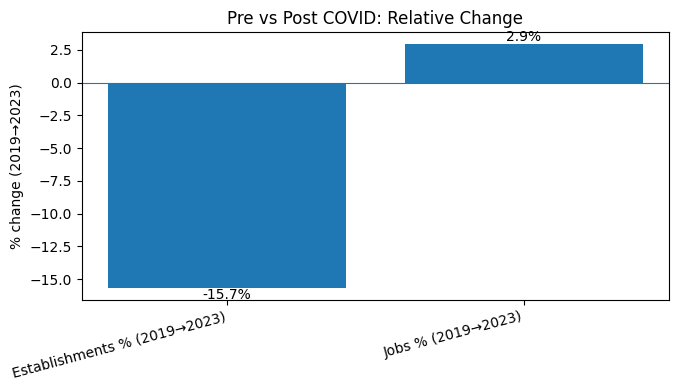

In [14]:
# Choose comparison years present in the data
PRE_YEAR  = 2019
POST_YEAR = 2023 if (biz["year"] >= 2023).any() else int(biz["year"].max())

# Build a small table to plot
biz_year_sums = biz.groupby("year")[["total_establishments","total_jobs"]].sum().reset_index()

summary = pd.Series({
    "Establishments % (2019→{})".format(POST_YEAR): pct_change_between_years(biz_year_sums, "total_establishments", "year", PRE_YEAR, POST_YEAR),
    "Jobs % (2019→{})".format(POST_YEAR): pct_change_between_years(biz_year_sums, "total_jobs", "year", PRE_YEAR, POST_YEAR),
}).round(2)

display(summary.to_frame("Percent change"))

plt.figure(figsize=(7,4))
bars = plt.bar(summary.index, summary.values)
plt.axhline(0, linewidth=0.8)
plt.ylabel(f"% change ({PRE_YEAR}→{POST_YEAR})")
plt.title("Pre vs Post COVID: Relative Change")
plt.xticks(rotation=15, ha="right")

# add value labels
for r, v in zip(bars, summary.values):
    plt.text(r.get_x()+r.get_width()/2, v, f"{v:.1f}%", ha="center", va="bottom" if v>=0 else "top")

plt.tight_layout(); plt.show()




# 9. Interpretation (Mid-Trimester)

##- **Small establishments:** Fell by **−15.8%** from 2019→2023, indicating a contraction in the number of active small businesses.  
##- **Small jobs:** Rose slightly by **+2.9%** over the same period, suggesting employment was more resilient than the number of establishments.  
##- **Early signal:** The divergence (fewer establishments but stable/increasing jobs) hints at consolidation—fewer firms employing more people each, rather than broad-based small business growth.

# 10. Limitations
##- City-wide aggregation hides spatial variation (e.g., CBD vs. non-CBD recovery patterns).  
##- CLUE and Pedestrian datasets capture different constructs; correlations are descriptive only, not causal.  
##- 2020–2021 anomalies reflect COVID restrictions; seasonal patterns are not adjusted here.

# 11. Next Steps (for end-of-trimester)
##- Break down by **industry sector** to identify which sectors drove the −15.8% establishment decline vs. the +2.9% jobs increase.  
##- Compare **CBD-only sensors** against whole-city pedestrian counts to test sensitivity.  
##- Extend analysis to **2024 data** once available; apply monthly/quarterly smoothing to account for seasonality.  
##- Explore basic correlation (e.g., Spearman) between annual foot traffic and small-business metrics for early quantitative signals.



# 12. Reproducibility
# - **Environment:** Python 3.x, pandas, matplotlib
# - **Inputs:** loaded directly from public CSV endpoints (see Section 2)
# - **How to run:** Execute all cells, ensure internet access to City of Melbourne portal
#
# **Change Log:**
# - v0.1 (mid-trimester): Initial load, annual aggregation, visuals, %-change table, interpretation scaffold.
